# Lista 1
#### Daniel Borkowski, 266593

Co zrobiłem:
1. Dijkstra
2. A* dla kryterium czasowego
3. A* dla kryterium przesiadkowego

Czyli ogólnie zadanie pierwsze. Jeśli starczy mi czasu, to drugie zrobię na zajęcia po świętach, na których będziemy oddawać.
W poniższym pliku pochylimy się nad osiągami skonstruowanych algorytmów oraz przyczynami takowych. Objaśnienia pod wykonanymi komurkami. Życzę miłej lektury.

In [1]:
from solution import Solution
from matplotlib import pyplot as plt
from random import sample, seed
from tools import Stop
import pandas as pd
import os

In [2]:
s = Solution()

Generalnie sprawa wygląda tak, że Solution to klasa przykrywka mająca trzy algorytmy gotowe do mielenia: Dijkstre i A* dla kryterium czasowego i A* dla kryterium przesiadek. Te *algorytmy* to po prostu klasa z przygotowaną strukturą (grafem), mająca metodę umożliwiającą puszczenie określonego wejścia (przystanków i czasu) do algorytmu i zwrócenie wyników. Te klasy z grafami implementują wspólny interfejs *Algorithm*.

Można byłoby to też skonstruować tak, że każde rozwiązanie jest obiektem pewnej klasy. Uprościło by to być może ewentualną serializację wyników (cacheowanie). Inne podejście, tutaj niestosowane.

## Krótki opis zastosowanych rozwiązań i założeń:
#### Przystanek jest identyfikowany wyłącznie przez nazwę
To uproszczenie zwalnia nas z obliczania czasu przejścia w ramach przysiadku między przystankami o tej samej nazwie, co nierzadko miałoby zapewne miejsce (gdyż często takie przystanki znajdują się koło siebie). Po uproszczeniu w takiej sytuacje przejście z przystanku na przystanek jest równoważne zwykłej przesiadce, ze stałą *change_time* czasu na przesiadkę. Upraszcza to nieco graf, rodząc jednak kilka problemów jeśli chodzi o kryterium przesiadkowe: gdy pojazdy tej samej linii np. jadące w dwóch przeciwnych kierunkach spotykają się, przejście z jednego do drugiego nie będzie traktowane jako przesiadka (a wymagałaby przecież czasu i obniżałaby wartość rozwiązania). Rozwiązaniem jest identyfikacja przystanków przez współrzędne geograficzne, jednak to wymagałoby dodatkowych rozwiązań umożliwiających kalkulację przejścia pomiędzy przystankami (co jeżeli np. w ogóle szybciej będzie całą trasę pokonać z buta, bo jest noc i przez najbliższe 6 godzin nie odjedzie żaden autobus?).
#### Kryterium czasowe
Graf skierowany, gdzie wierzchołki to poszczególne przystanki, a krawędź od wierzchołka *A* do wierzchołka *B* jest listą wszystkich kursów w rozkładzie pomiędzy tymi przystankami. Każda wizyta we wierzchołku *A* obejmuje przegląd kursów do wielu *N*, gdzie *N* to każdy sąsiad z osobna, i wybór takiego kursu, który jest w przyszłości względem naszej (wirtualnej) obecności w węźle *A*, a który odjeżdża najwcześniej. Ulepszeniami byłyby: niesprawdzanie *N*, dla którego nasze *A* było **poprzednio** *N* (czyli poprzedniego przystanku, bo to bez sensu żeby się cofać), czy też preobliczenie wszystkich 1440 grafów dla poszczególnych minut, a wówczas przejście algorytmem po jednym z grafów nie byłoby obarczone czasem wyboru kursu.
#### Kryterium przesiadkowe:
Graf skierowany, gdzie wierzchołki to poszczególne przystanki, z których może odjechać dana linia (linio-przystanki), a krawędzie to możliwe połączenia między nimi. Dla przystanku *A* mamy zbiór linio-przystanków *P*, a dla przystanku *B* zbiór *R*. Jeśli z przystanku *A* linią, która wraz z tym przystankiem formuje *p* (które jest wierzchołkiem grafu) należące do, *P* da się dojechać do przystanku *B*, to z *p* biegnie krawędź skierowana do każdego *r* należącego do *R*. Na potrzeby algorytmu zaczynamy od sztucznego przystanku, gdzie poprzednia linia to *None*, co symuluje równoczesne wyjście wszystkimi liniami z przystanku startowego (we wszystkie strony, jeśli rozpatrujemy nasz graf, redukując wymiar, na mapie, tak jak graf w kryterium czasowym). *De facto* krawędzie zawierają listy połączeń, które tak jak w poprzednim przypadku w czasie wykonywania algorytmu podlegają selekcji. Ponownie rozwiązanie dałoby się ulepszyć preobliczeniami, jednak każdy z grafów będzie znacznie większy.
#### Dlaczego dwa różne grafy?
Bo graf z przystankami jako wierzchołkami nie wystarczy dla rozpatrywania kryterium przesiadek. Czekamy na jakiś autobus na przystanku *A*, do przystanku *B*: jeden jest za minutę, drugi za godzinę, obie z różnych linii. Który z nich wybrać? Który sprawi, że dojedziemy do przystanku *C* mniejszą liczbą przesiadek? Oczywiste, że bardziej korzystny (lub neutralny) dla kryterium czasowego będzie wybór wcześniejszego połączenia, jednak nie dla kryterium przesiadek. Dlatego musimy rozpatrzeć oba autobusy, przy czym jeśli pierwszy z nich jest linii *K*, a drugi *L*, to wystarczy rozpatrzyć tylko jeden kurs między dwoma przystankami dla danej linii - czas jest istotny o tyle jedynie, że zwrócony musi być plan przejazdu. Problem rodzi się, gdy pojazd jedzie niestandardową ścieżką, np. do zajezdni, na co niestety ów algorytm jest wrażliwy. Wówczas trzeby by było rozpatrywać więcej kursów dla danej linii i przystanku.

## Analiza danych
rzed rozpoczęciem pisania algorytmów została przeprowadzona analiza, która wpłynęła na kształt końcowego rozwiązania. Poniżej najważniejsze informacje na temat problemu oraz struktury rozwiązania.

In [3]:
print("|V|=",len(s.a_star.graph.keys()))
counter = 0
for neighbor in s.a_star.graph.values():
    counter+=len(neighbor)
print("|E|=",counter)

|V|= 939
|E|= 2343


W grafie do kryterium czasowego jest 939 wierzchołków i 2343 krawędzie.

In [4]:
v = 0
e = 0
for stop, neighbors in s.a_star_changes.graph.items():
    for neighbor, lines in neighbors.items():
        v+=len(lines)
        for line, routes in lines.items():
            e+=len(routes)
print("|V|=",v)
print("|E|=",e)

|V|= 9151
|E|= 455231


W grafie dla kryterium przystanków jest 9151 wierzchołków (linioprzystanków) i 455231 krawędzi (możliwych połączeń między nimi). To jest horrendalnie dużo i dobrze byłoby wymyślić inny pomysł, jeśli jest możliwy. 

## Heurystyki
Zastosowano poniższe heurystyki, aby umożliwić optymalizację funkcji kosztu dla algorytmy A*.

In [5]:
def euclidean(next_node: Stop, end_node: Stop) -> float:
        # distance in kilometers / 120 as optimistic velocity in km/h = optimistic time in hours
        # optimistic time in hours * 60 as minutes in an hour = optimistic time in minutes
        return 60 * geodesic((next_node.latitude,next_node.longitude), 
                             (end_node.latitude,end_node.longitude)).kilometers / 120

Dla kryterium czasowego obliczamy czas, jaki zajęłoby nam dotarcie do końca trasy jadąc 120 km/h po linii prostej. Jest to z pewnością bardzo optymistyczne. Nieużycie funkcji heurystycznej byłoby przeszukiwaniem ślepo na wszystkie strony, rozwijając równomiernie trasy od źródła we wszystkie strony, natomiast użycie nieoptymistycznej funkcji kosztu odstraszy nas od kierunku, w którym podążamy. Czy udało nam się to osiągnąć? O tym nieco poniżej.

In [6]:
def approaching(prev_node: Stop, next_node: Stop, end_node: Stop) -> float:
        # charge coming further away from target
        prev_dist = geodesic((prev_node.latitude,prev_node.longitude), (end_node.latitude,end_node.longitude)).meters
        next_dist = geodesic((next_node.latitude,next_node.longitude), (end_node.latitude,end_node.longitude)).meters
        return 0 if next_dist < prev_dist else further_charge

Dla kryterium przesiadkowego sprawdzamy, czy aktualny fragment trasy (połączenie, które rozpatrujemy) w porównaniu z poprzednim zbliżył nas do celu, czy nie. Jeśli zbliżył, to nie dodajemy nic, jeśli oddalił, to dodajemy `further_charge` (w naszym rozwiązaniu o wartości `0.1`). Musimy sobie zdawać sprawę, że funkcja kosztu przyjmuje za wartości liczby naturalne, w wypadku naszego problemu nieduże, 1, 2, 3 w rozwiązaniach, które zmierzają do celu. Czy zaproponowana heurystyka jest optymistyczna? Wręcz na pewno nie, przynajmniej nie dla wszystkich przypadków. Nie da się bowiem stwierdzić czy tramwaj, który teraz przejechał na wschód, zamiast na zachód, gdzie jest nasz przystanek docelowy, zaraz nie zakręci i nie będzie jechał do końca do celu, a tym samym pozwoli nam dojechać tam bez przesiadki; nie da się tego stwierdzić na podstawie tego, że teraz przejechał na wschód. Można by pewnie jakoś zmapować dwuwymiarową przestrzeń miasta, aby określić ile z dowolnego punktu A do dowolnego punktu B będzie przesiadek, tworząc za pomocą metod matematycznych wielowymiarową mapę; jednakże jeszcze chwila i będzie to równoważne naszemu algorytmowi. Generalnie więc nie możemy być pewni co do optymistyczności naszej heurystyki, jednak problem wydaje się być na tyle trudny, że warto przynajmniej spróbować. Nieużycie żadnej heurystyki będzie premiowało rozwiązania, które jadą do końca, czyli będzie przeszukiwaniem grafu w głąb. Zbytnia pesymistyczność klasycznie będzie odstraszać od zakręcających "zaraz" rozwiązań. Jednakże, skoro zbiór wartości funkcji jest tak specyficzny i najlepiej by było, gdyby wynosił 0, to nie mamy dużego pola do wyboru, nie przebudowując funkcji kosztu, która jednakże w tym problemie jest wprost podana w zadaniu.

## Porównanie osiągów Dijkstry i A* dla kryterium czasowego

Ze względu na opracowanie powyższych uważam to porównanie za zasadne. Założenie jest takie, że A* z odpowiednio dobraną heurystyką umożliwi znalezienie optymalnego rozwiązania w krótszym czasie, redukując przeszukaną przestrzeń.

Źle opracowana heurystyka (gdy jest nieoptymistyczna) nie gwarantuje znalezienia rozwiązania optymalnego lub opóźnia rzeczywisty czas działania algorytmu (gdy nie przyspiesza znalezienia rozwiązania, a jej obliczanie jest kosztowne).

In [60]:
seed('chalamet')
fname = 'records.csv'
if not os.path.isfile(fname):
    routes = pd.read_csv('connection_graph (1).csv', low_memory=False)
    routes.set_index(keys='Unnamed: 0', inplace=True)
    routes.drop_duplicates(ignore_index=True, inplace=True)
    chosen_start = routes['start_stop']
    chosen_end = routes['end_stop']
    chosen_start.drop_duplicates(inplace=True)
    chosen_end.drop_duplicates(inplace=True)
    product = []
    for i in chosen_start:
        for j in chosen_end:
            product.append((i,j))
    with open(fname, 'w', encoding='utf-8-sig') as f:
        for pair in sample(product,1000):
            a,b = pair
            cost_d, time_d = s.find(a,b,'23:15:00',criteria='d', debug=False)
            cost_t, time_t = s.find(a,b,'23:15:00',criteria='t', debug=False)
            print(a,b,cost_d,time_d,cost_t,time_t, sep=',', file=f)
comparison = pd.read_csv('records.csv', header=None).rename(columns={i: ['start','end','d_cost','d_time','t_cost','t_time'][i] 
                                                        for i in range(6)})

Powyższy skrypt jest dosyć kosztowny, jego odpalenie zajęło 14 minut. Tworzy on zestawienie do analizy porównawczej algorytmów. Analizujemy tysiąc zestawień par przystanków w godzinach nocnych. *d* Dijkstra, *t* A*.

In [8]:
comparison[comparison['d_cost'] > comparison ['t_cost']]

,start,end,d_cost,d_time,t_cost,t_time
758,WAŁBRZYSKA,Chełmońskiego,94.0,0.281846,66.0,0.279264


To wskazuje na jakiś błąd w algorytmach, Dijkstra musi bowiem zwracać rozwiązanie optymalne. Prawdopodobnie algorytm zabłądził jakimś kursem o niestandardowej trasie. Nie będziemy

In [18]:
a,b = 'WAŁBRZYSKA', 'Chełmońskiego'
cost_d, time_d = s.find(a,b,'23:15:00',criteria='t', debug=True)

From WAŁBRZYSKA at 23:15:00:
 1. 	107) [23:17] WAŁBRZYSKA                 - [23:18] Marchewkowa (Day 4.0)
 2. 	107) [23:18] Marchewkowa                - [23:19] Morelowskiego (Day 4.0)
 3. 	107) [23:19] Morelowskiego              - [23:20] Adamieckiego (Day 4.0)
 4. 	107) [23:20] Adamieckiego               - [23:21] Wiejska (Day 4.0)
 5. 	107) [23:21] Wiejska                    - [23:22] Solskiego (Day 4.0)
 6. 	107) [23:22] Solskiego                  - [23:23] OPORÓW (Day 4.0)
 7. 	107) [23:24] OPORÓW                     - [23:25] GRABISZYŃSKA (Cmentarz) (Day 4.0)
 8. 	 11) [23:25] GRABISZYŃSKA (Cmentarz)    - [23:26] Fiołkowa (Day 4.0)
 9. 	 11) [23:26] Fiołkowa                   - [23:27] FAT (Day 4.0)
10. 	 11) [23:27] FAT                        - [23:29] Aleja Pracy (Day 4.0)
11. 	125) [23:30] Aleja Pracy                - [23:31] Inżynierska (Day 4.0)
12. 	125) [23:31] Inżynierska                - [23:32] Kolbuszowska (Stadion) (Day 4.0)
13. 	125) [23:32] Kolbuszowska (Stadion)   

Cost function: 66
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.3600144386291504 seconds since start 
	0.3600144386291504 seconds since proceeding start
--- printing end: 0.3600144386291504 seconds since start 
	0.0 seconds since printing start


Tak wygląda output dla *A\**.

In [10]:
print(s.dijkstra.stops_records[Stop('Międzyrzecka',0,0)].last_stop, s.dijkstra.stops_records[Stop('Międzyrzecka',0,0)].min_arrival_minutes)
print(s.a_star.stops_records[Stop('Międzyrzecka',0,0)].last_stop, s.a_star.stops_records[Stop('Międzyrzecka',0,0)].g)

Armii Krajowej[51.086705, 17.06947] 1458
Armii Krajowej[51.086705, 17.06947] 1458


A tu widać, że algorytmy rozjeżdżają się na przedostatnim przystanku poprawnej trasy - do jednego wiedzie zupełnie inna trasa niż do drugiego. Najlepiej gdyby trasy te były identyczne, a na pewno ta Dijkstry nie może być mniej korzystna, jeśli trasa jest optymalna.

In [11]:
comparison[comparison['d_cost'] < comparison ['t_cost']]

,start,end,d_cost,d_time,t_cost,t_time
118,Jaksonowice (na wys. nr 27),Jaworowa,444.0,0.247649,446.0,0.468159
151,Gajowicka,Karwińska,62.0,0.274876,122.0,0.415803


Teraz dobre wiadomości: tylko w dwóch z tysiąca przypadków znalezione rozwiązanie jest nieoptymalne. Raz co prawda o godzinę, ale... Warto sprawdzić co to za trasa.

In [12]:
a,b = 'Gajowicka', 'Karwińska'
cost_d, time_d = s.find(a,b,'23:15:00',criteria='d', debug=True)
cost_d, time_d = s.find(a,b,'23:15:00',criteria='t', debug=True)

From Gajowicka at 23:15:00:
 1. 	 20) [23:21] Gajowicka                  - [23:22] Mielecka (Day 1)
 2. 	 20) [23:22] Mielecka                   - [23:23] Ojca Beyzyma (Day 1)
 3. 	 20) [23:23] Ojca Beyzyma               - [23:25] Aleja Pracy (Day 1)
 4. 	125) [23:30] Aleja Pracy                - [23:31] Inżynierska (Day 1)
 5. 	125) [23:31] Inżynierska                - [23:32] Kolbuszowska (Stadion) (Day 1)
 6. 	125) [23:32] Kolbuszowska (Stadion)     - [23:33] Krucza (Mielecka) (Day 1)
 7. 	125) [23:33] Krucza (Mielecka)          - [23:34] Krucza (Day 1)
 8. 	134) [23:34] Krucza                     - [23:36] Rondo (Day 1)
 9. 	134) [23:36] Rondo                      - [23:38] Drukarska (Day 1)
10. 	134) [23:38] Drukarska                  - [23:39] Uniwersytet Ekonomiczny (Day 1)
11. 	134) [23:39] Uniwersytet Ekonomiczny    - [23:41] Borowska (Aquapark) (Day 1)
12. 	134) [23:41] Borowska (Aquapark)        - [23:42] Wapienna (Day 1)
13. 	134) [23:42] Wapienna                   - [23:43

Cost function: 35
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.5338630676269531 seconds since start 
	0.5338630676269531 seconds since proceeding start
--- printing end: 0.5338630676269531 seconds since start 
	0.0 seconds since printing start


From Gajowicka at 23:15:00:
 1. 	 20) [23:21] Gajowicka                  - [23:22] Mielecka (Day 4.0)
 2. 	 20) [23:22] Mielecka                   - [23:23] Ojca Beyzyma (Day 4.0)
 3. 	 20) [23:23] Ojca Beyzyma               - [23:25] Aleja Pracy (Day 4.0)
 4. 	125) [23:30] Aleja Pracy                - [23:31] Inżynierska (Day 4.0)
 5. 	125) [23:31] Inżynierska                - [23:32] Kolbuszowska (Stadion) (Day 4.0)
 6. 	125) [23:32] Kolbuszowska (Stadion)     - [23:33] Krucza (Mielecka) (Day 4.0)
 7. 	125) [23:33] Krucza (Mielecka)          - [23:34] Krucza (Day 4.0)
 8. 	134) [23:34] Krucza                     - [23:36] Rondo (Day 4.0)
 9. 	134) [23:36] Rondo                      - [23:38] Drukarska (Day 4.0)
10. 	134) [23:38] Drukarska                  - [23:39] Uniwersytet Ekonomiczny (Day 4.0)
11. 	134) [23:39] Uniwersytet Ekonomiczny    - [23:41] Borowska (Aquapark) (Day 4.0)
12. 	134) [23:41] Borowska (Aquapark)        - [23:42] Wapienna (Day 4.0)
13. 	134) [23:42] Wapienna   

Cost function: 35
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.3688161373138428 seconds since start 
	0.3688161373138428 seconds since proceeding start
--- printing end: 0.3688161373138428 seconds since start 
	0.0 seconds since printing start


Dlaczego na tym pozornie prostym odcinku *A\** okazało się słabsze? Być może ponieważ optymalna trasa wymaga pojechania na początku w przeciwnym kierunku, co algorytm odłożył tak daleko, że prędzej znalazł nieoptymalne rozwiązanie pędzące ku celowi.

In [13]:
len(comparison[comparison['d_time'] > comparison['t_time']]) / len(comparison)

0.225

Absolutna porażka, *A\** powinnien być efektywniejszy czasowo, w sumie po to go używamy. Przyjrzyjmy się rozkładom tych wartości.

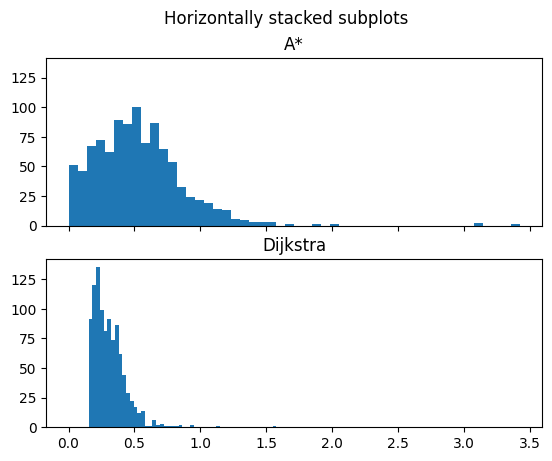

In [14]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)
fig.suptitle('Horizontally stacked subplots')
axs[0].hist(comparison['t_time'], bins=50)
axs[0].set_title("A*")
axs[1].hist(comparison['d_time'], bins=50)
axs[1].set_title("Dijkstra")
plt.show()

Dijkstra zawsze zajmuje powyżej 0.1 sekundy, A* czasem schodzi poniżej tę wartość. Logiczne, bo zawsze musi przejśc przez cały graf, podczas gdy bywa, że *A\** od razu znajduje rozwiązanie. W większości przypadków jednak *A\** osiąga słabsze wyniki od Dijkstry co jest bez sensu. Prawdopodobnie wynika to z tego, że *a)* heurystyka może być zbytnio obciążająca obliczeniowo lub *b)* może zbyt słabo kierować nas ku celowi. Może to też wynikać z doboru danych przez samplowanie, które jest w pełni losowe. Warto byłoby powtórzyć te doświadczenia dla innych hiperparametrów np. *prędkości* w heurystyce lub po prostu dla innej heurystyki.

In [15]:
seed('chalamet')
fname = 'records_changes.csv'
if not os.path.isfile(fname):
    routes = pd.read_csv('connection_graph (1).csv', low_memory=False)
    routes.set_index(keys='Unnamed: 0', inplace=True)
    routes.drop_duplicates(ignore_index=True, inplace=True)
    chosen_start = routes['start_stop']
    chosen_end = routes['end_stop']
    chosen_start.drop_duplicates(inplace=True)
    chosen_end.drop_duplicates(inplace=True)
    product = []
    for i in chosen_start:
        for j in chosen_end:
            product.append((i,j))
    with open(fname, 'w', encoding='utf-8-sig') as f:
        for pair in sample(product,50):
            a,b = pair
            cost, time = s.find(a,b,'23:15:00',criteria='p', debug=False)
            print(a,b,cost,time, sep=',', file=f)
changes = pd.read_csv('records_changes.csv', header=None).rename(columns={i: ['start','end','p_cost','p_time'][i] 
                                                        for i in range(4)})

In [16]:
changes['p_time'].agg('average')

173.18388511657716

Średnio na wynik dla kryterium przesiadek czekamy prawie 3 minuty. Luźno badając wcześniej pojawiały się wyniki rzędu 20-30s, dla standardowo wyszukiwanych połączeń.

# Podsumowanie

In [17]:
a,b = 'DWORZEC NADODRZE', 'Tramwajowa'
time = '8:17:00'
print('A* przesiadki:')
s.find(a,b,time,criteria='p', debug=True)
print('A* czas:')
s.find(a,b,time,criteria='t', debug=True)
print('Dijkstra:')
s.find(a,b,time,criteria='d', debug=True)

A* przesiadki:
From DWORZEC NADODRZE at 8:17:00:
 1. 	1) [08:28] DWORZEC NADODRZE                  - [08:30] Słowiańska (Day 1)
 2. 	1) [08:30] Słowiańska                        - [08:32] Nowowiejska (Day 1)
 3. 	1) [08:32] Nowowiejska                       - [08:34] Wyszyńskiego (Day 1)
 4. 	1) [08:34] Wyszyńskiego                      - [08:35] Prusa (Day 1)
 5. 	1) [08:35] Prusa                             - [08:37] Piastowska (Day 1)
 6. 	1) [08:37] Piastowska                        - [08:40] PL. GRUNWALDZKI (Day 1)
 7. 	1) [08:41] PL. GRUNWALDZKI                   - [08:42] Kliniki - Politechnika Wrocławska (Day 1)
 8. 	1) [08:42] Kliniki - Politechnika Wrocławska - [08:44] Hala Stulecia (Day 1)
 9. 	1) [08:44] Hala Stulecia                     - [08:45] ZOO (Day 1)
10. 	1) [08:45] ZOO                               - [08:46] Tramwajowa (Day 1)
A* czas:
From DWORZEC NADODRZE at 8:17:00:
 1. 	16) [08:19] DWORZEC NADODRZE                  - [08:21] Słowiańska (Day 3.0)
 2. 	16) [08:2

Cost function: 0
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 6.097287893295288 seconds since start 
	6.097287893295288 seconds since proceeding start
--- printing end: 6.097287893295288 seconds since start 
	0.0 seconds since printing start
Cost function: 20
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.17232108116149902 seconds since start 
	0.17232108116149902 seconds since proceeding start
--- printing end: 0.17232108116149902 seconds since start 
	0.0 seconds since printing start


From DWORZEC NADODRZE at 8:17:00:
 1. 	16) [08:19] DWORZEC NADODRZE                  - [08:21] Słowiańska (Day 1)
 2. 	16) [08:21] Słowiańska                        - [08:23] Nowowiejska (Day 1)
 3. 	16) [08:23] Nowowiejska                       - [08:25] Wyszyńskiego (Day 1)
 4. 	16) [08:25] Wyszyńskiego                      - [08:26] Prusa (Day 1)
 5. 	16) [08:26] Prusa                             - [08:28] Piastowska (Day 1)
 6. 	16) [08:28] Piastowska                        - [08:31] PL. GRUNWALDZKI (Day 1)
 7. 	10) [08:31] PL. GRUNWALDZKI                   - [08:33] Kliniki - Politechnika Wrocławska (Day 1)
 8. 	10) [08:33] Kliniki - Politechnika Wrocławska - [08:35] Hala Stulecia (Day 1)
 9. 	10) [08:35] Hala Stulecia                     - [08:36] ZOO (Day 1)
10. 	10) [08:36] ZOO                               - [08:37] Tramwajowa (Day 1)


Cost function: 20
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.24552321434020996 seconds since start 
	0.24552321434020996 seconds since proceeding start
--- printing end: 0.24552321434020996 seconds since start 
	0.0 seconds since printing start


(20, 0.24552321434020996)

I tym optymistycznym akcentem zakończmy: heurystyki zadziałały, optymalne rozwiązania zostały znalezione, *A\** dla kryterium przesiadek zajął tylko kilka sekund, a dla kryterium czasowego był szybszy niż Dijkstra.

Zadanie częściowo można uznać za udane. Opracowano rozwiązania, które działają obiecująco dla ograniczonych przypadków testowych, jednak zapewne w wyniku niewykrytych błędów i narzutów czasowych lub strukturalnych wyniki dla testów przekrojowych bynajmniej nie są obiecujące.
## Wnioski:
1. Struktura może być zbyt zagmatwana.
2. Heurystyka może nie być podkręcona dostatecznie.
3. Na wykonanie tej listy potrzeba znacznie więcej czasu (i sił).

## Dodatek
### 08.04.2024

Po analizie doszedłem do wniosku, że czynnikiem, który sprawia, że powodem, przez który Dijkstra nie znajduje optymalnej ścieżki (skandaliczne) jest istnienie czasu na przesiadkę, który przy obranym work-flow może nas wyprowadzić w pole. Po zmianie w skrypcie (gdyż niestety zmienna nie została przypisana do obiektu *Solution*) przeliczono wątpliwy przypadek ponownie.

In [23]:
a,b = 'WAŁBRZYSKA', 'Chełmońskiego'
cost_d, time_d = s.find(a,b,'23:15:00',criteria='d', debug=True)
cost_d, time_d = s.find(a,b,'23:15:00',criteria='t', debug=True)

From WAŁBRZYSKA at 23:15:00:
 1. 	107) [23:17] WAŁBRZYSKA                 - [23:18] Marchewkowa (Day 1)
 2. 	107) [23:18] Marchewkowa                - [23:19] Morelowskiego (Day 1)
 3. 	107) [23:19] Morelowskiego              - [23:20] Adamieckiego (Day 1)
 4. 	107) [23:20] Adamieckiego               - [23:21] Wiejska (Day 1)
 5. 	107) [23:21] Wiejska                    - [23:22] Solskiego (Day 1)
 6. 	107) [23:22] Solskiego                  - [23:23] OPORÓW (Day 1)
 7. 	107) [23:24] OPORÓW                     - [23:25] GRABISZYŃSKA (Cmentarz) (Day 1)
 8. 	 11) [23:25] GRABISZYŃSKA (Cmentarz)    - [23:26] Fiołkowa (Day 1)
 9. 	 11) [23:26] Fiołkowa                   - [23:27] FAT (Day 1)
10. 	 11) [23:27] FAT                        - [23:29] Aleja Pracy (Day 1)
11. 	125) [23:30] Aleja Pracy                - [23:31] Inżynierska (Day 1)
12. 	125) [23:31] Inżynierska                - [23:32] Kolbuszowska (Stadion) (Day 1)
13. 	125) [23:32] Kolbuszowska (Stadion)     - [23:33] Krucza (Miel

Cost function: 66
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.33263707160949707 seconds since start 
	0.33263707160949707 seconds since proceeding start
--- printing end: 0.33263707160949707 seconds since start 
	0.0 seconds since printing start


From WAŁBRZYSKA at 23:15:00:
 1. 	107) [23:17] WAŁBRZYSKA                 - [23:18] Marchewkowa (Day 4.0)
 2. 	107) [23:18] Marchewkowa                - [23:19] Morelowskiego (Day 4.0)
 3. 	107) [23:19] Morelowskiego              - [23:20] Adamieckiego (Day 4.0)
 4. 	107) [23:20] Adamieckiego               - [23:21] Wiejska (Day 4.0)
 5. 	107) [23:21] Wiejska                    - [23:22] Solskiego (Day 4.0)
 6. 	107) [23:22] Solskiego                  - [23:23] OPORÓW (Day 4.0)
 7. 	107) [23:24] OPORÓW                     - [23:25] GRABISZYŃSKA (Cmentarz) (Day 4.0)
 8. 	 11) [23:25] GRABISZYŃSKA (Cmentarz)    - [23:26] Fiołkowa (Day 4.0)
 9. 	 11) [23:26] Fiołkowa                   - [23:27] FAT (Day 4.0)
10. 	 11) [23:27] FAT                        - [23:29] Aleja Pracy (Day 4.0)
11. 	125) [23:30] Aleja Pracy                - [23:31] Inżynierska (Day 4.0)
12. 	125) [23:31] Inżynierska                - [23:32] Kolbuszowska (Stadion) (Day 4.0)
13. 	125) [23:32] Kolbuszowska (Stadion)   

Cost function: 66
--- start: 0.0 seconds since start 
	0.0 seconds since start
--- proceeding end: 0.282085657119751 seconds since start 
	0.282085657119751 seconds since proceeding start
--- printing end: 0.282085657119751 seconds since start 
	0.0 seconds since printing start


I widać, że tym razem intuicja nie wyprowadziła mnie w pole. Przeliczmy zatem ponownie porównawcze przykłady.

In [52]:
seed('chalamet')
fname = 'records_repaired.csv'
if not os.path.isfile(fname):
    routes = pd.read_csv('connection_graph (1).csv', low_memory=False)
    routes.set_index(keys='Unnamed: 0', inplace=True)
    routes.drop_duplicates(ignore_index=True, inplace=True)
    chosen_start = routes['start_stop']
    chosen_end = routes['end_stop']
    chosen_start.drop_duplicates(inplace=True)
    chosen_end.drop_duplicates(inplace=True)
    product = []
    for i in chosen_start:
        for j in chosen_end:
            product.append((i,j))
    with open(fname, 'w', encoding='utf-8-sig') as f:
        for pair in sample(product,1000):
            a,b = pair
            cost_d, time_d = s.find(a,b,'23:15:00',criteria='d', debug=False)
            cost_t, time_t = s.find(a,b,'23:15:00',criteria='t', debug=False)
            print(a,b,cost_d,time_d,cost_t,time_t, sep=',', file=f)
comparison_repaired = pd.read_csv(fname, header=None).rename(columns={i: ['start','end','d_cost','d_time','t_cost','t_time'][i] 
                                                        for i in range(6)})

In [53]:
comparison_repaired[comparison_repaired['d_cost'] > comparison_repaired ['t_cost']]

,start,end,d_cost,d_time,t_cost,t_time


In [54]:
comparison_repaired[comparison_repaired['d_cost'] < comparison_repaired ['t_cost']]

,start,end,d_cost,d_time,t_cost,t_time


Widzimy, że wyniki pod względem poprawności są znacznie lepsze:
- nie ma przypadków, w których Dijkstra wskazuje gorsze rozwiązanie niż *A\**
- nie ma przypadków, w których *A\** wskazuje gorsze rozwiązanie niż Dijkstra
Czy jednak o to nam chodziło? *A\* miał być przede wszystkim szybszy, czego niestety nie udało nam się osiągnąć.

In [57]:
len(comparison_repaired[comparison_repaired['d_time'] > comparison_repaired['t_time']]) / len(comparison_repaired)

0.242

Nasze osiągi czasowe nie uległy polepszeniu, czego zestawienie widać na poniższym diagramie.

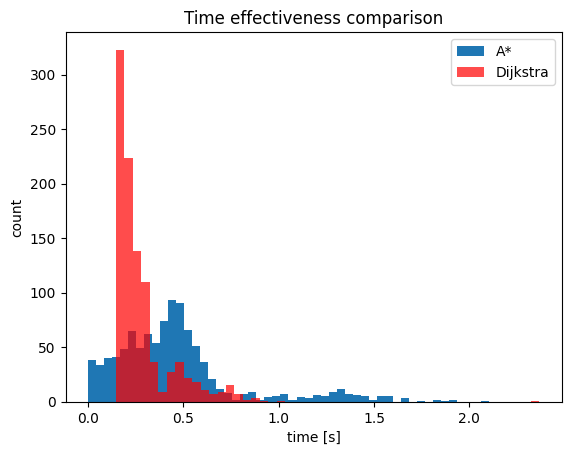

In [59]:
plt.title('Time effectiveness comparison')
plt.hist(comparison_repaired['t_time'], bins=50, label='A*')
plt.hist(comparison_repaired['d_time'], bins=50, label='Dijkstra', alpha=0.7, color='red')
plt.ylabel("count")
plt.xlabel("time [s]")
plt.legend()
plt.show()

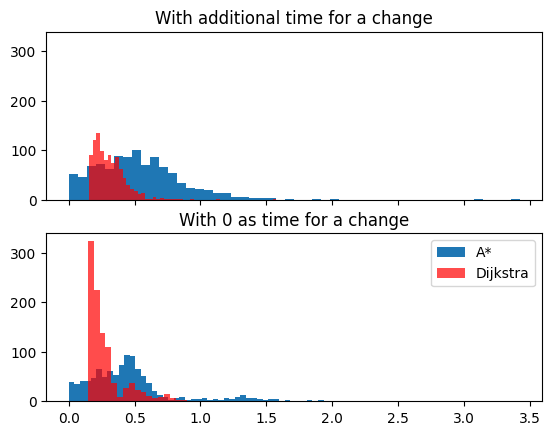

In [69]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)
axs[0].hist(comparison['t_time'], bins=50, label='A*')
axs[0].hist(comparison['d_time'], bins=50, alpha=0.7, color='red', label='Dijkstra')
axs[0].set_title("With additional time for a change")
axs[1].hist(comparison_repaired['t_time'], bins=50, label='A*')
axs[1].hist(comparison_repaired['d_time'], bins=50, alpha=0.7, color='red',  label='Dijkstra')
axs[1].set_title("With 0 as time for a change")
plt.legend()
plt.show()

Widzimy przede wszystkim, że teraz algorytmy znajdują rozwiązanie szybciej - wykres jest bardziej przechylony ku lewej stronie. Ze wcześniejszego wykresu wiemy, że również wartości skrajne uległy przybliżeniu do średniej.

In [86]:
print(f"A* median time before\t\t: {comparison['t_time'].median()} s\t and after :  {comparison_repaired['t_time'].median()} s")
print(f"Dijkstra median time before\t: {comparison['d_time'].median()} s\t and after :  {comparison_repaired['d_time'].median()} s")

A* median time before		: 0.4973747730255127 s	 and after :  0.41730332374572754 s
Dijkstra median time before	: 0.28616011142730713 s	 and after :  0.22530710697174067 s


Co skutkowało ogólnemu polepszeniu osiągów obu algorytmów.